In [ ]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Reshape
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#데이터 불러오기(경로)
train_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_x_df.csv')
train_y_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_y_df.csv')
test_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/test_x_df.csv')
sample_submission=pd.read_csv('/content/drive/MyDrive/capstone2021/sample_submission.csv')
train_x_df = train_x_df.astype('float')
train_y_df = train_y_df.astype('float')
test_x_df = test_x_df.astype('float')
sample_submission=sample_submission.astype('float')

In [ ]:
# 3차원 array로 변경
def df2d_to_array3d(df_2d):

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

def kbindiscreter(input_array):
  kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal')
  processed_data = np.zeros((input_array.shape[0], input_array.shape[1], 1))
  for i in range(input_array.shape[0]):
    # coin_index_export args : (input_array, coin_num)
    processing_array = input_array[i,:,1]
    #globals()['outliery_array{}'.format(i)] = train_y_array[outlier[i],:,1]
    kb.fit(processing_array.reshape(input_array.shape[1],1))
    processed_fit = kb.transform(processing_array.reshape(input_array.shape[1],1))
    #globals()['outliery_fit{}'.format(i)] = kb.transform(globals()['outliery_array{}'.format(i)].reshape(120,1))
    processed_data[i,:,:] = processed_fit
  return processed_data

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [ ]:
xarray = kbindiscreter(train_x_array)
yarray = kbindiscreter(train_y_array)

In [ ]:
df2 = xarray[:100,:].reshape(100,1380,1)

In [ ]:
X_train = []
y_train = []
n_future = 1 # Number of days we want to predict into the future.
n_past = 120 # Number of past days we want to use to predict future.
for idx in range(df2.shape[0]):
    for i in range(n_past, df2.shape[1] - n_future +1):
        X_train.append(df2[idx, i - n_past:i,:])
        y_train.append(df2[idx, i:i+n_future, ])
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (126000, 120, 1).
y_train shape == (126000, 1, 1).


In [ ]:
x_traina = np.zeros((X_train.shape[0],X_train.shape[1],10))
for i in range(X_train.shape[0]):
  for j in range(X_train.shape[1]):
    for k in range(10):
      if X_train[i,j,:] ==k:
        x_traina[i,j,k] =1

In [ ]:
y_traina = np.zeros((y_train.shape[0],10))
for i in range(y_train.shape[0]):
  for j in range(10):
    if y_train[i] == j:
      y_traina[i,j] = 1

In [ ]:
#Build the model
model = Sequential()
model.add(LSTM(64,return_sequences=False,activation = 'relu',input_shape= (x_traina.shape[1],x_traina.shape[2] )))
model.add(Dense(32))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_traina,y_traina,epochs=20, validation_split=0.2,shuffle=True)

Epoch 1/20
3150/3150 [==============================] - 184s 51ms/step - loss: 289511947.0202 - accuracy: 0.7623 - val_loss: 0.5891 - val_accuracy: 0.8155
Epoch 2/20
3150/3150 [==============================] - 161s 51ms/step - loss: 0.5818 - accuracy: 0.8100 - val_loss: 0.4868 - val_accuracy: 0.8440
Epoch 3/20
3150/3150 [==============================] - 160s 51ms/step - loss: 0.4968 - accuracy: 0.8362 - val_loss: 0.4634 - val_accuracy: 0.8543
Epoch 4/20
3150/3150 [==============================] - 166s 53ms/step - loss: 0.4792 - accuracy: 0.8447 - val_loss: 0.4552 - val_accuracy: 0.8572
Epoch 5/20
3150/3150 [==============================] - 164s 52ms/step - loss: 0.4679 - accuracy: 0.8500 - val_loss: 0.4540 - val_accuracy: 0.8629
Epoch 6/20
  49/3150 [..............................] - ETA: 2:29 - loss: 0.4537 - accuracy: 0.8712

KeyboardInterrupt: ignored

In [ ]:
# train 값 plotting

aa =x_traina[729:829,:,:] 
bb =y_traina[729:829,:]
predictions = model.predict(aa.reshape(100,120,10))

In [ ]:
# prediction 값 원 핫 인코딩 -> '정수값
fa = []
for i in range(100):
  fc = model.predict(aa[i].reshape(1,120,10))
  fa.append(np.argmax(fc))

In [ ]:
# real 값 원 핫 인코딩 -> '정수값
fb = []
for i in range(100):
  fb.append(np.argmax(bb[i]))

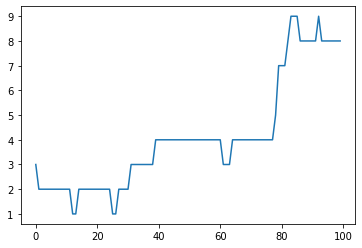

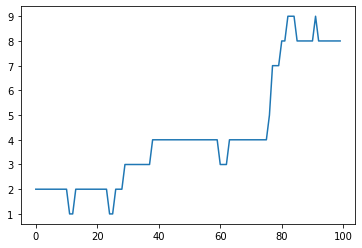

In [ ]:
#plotting
plt.plot(fa, label="predictions")
plt.show()
plt.plot(fb, label="real")

In [ ]:
#train set auto regression

aa =x_traina[800,:,:]
yhat=[]
x= aa.reshape(1,120,10)

In [ ]:
for i in range(100):
  x=x.reshape(1,120,10)
  fc = model.predict(x)
  yhat.append(np.argmax(fc))
  fd = np.zeros((1,10))
  for j in range(10):
    if j==np.argmax(fc):
      fd[0,j] = 1
  
  x=x.reshape(120,10)
  x=np.vstack([x,fd])
  x=x[1:,:]

In [ ]:
bb = []
for x in range(100):
  bb.append(np.argmax(y_traina[800+x]))

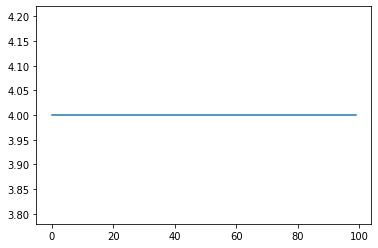

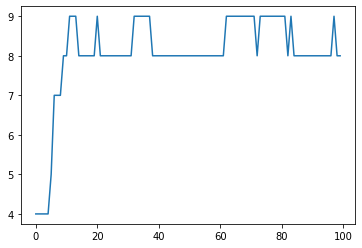

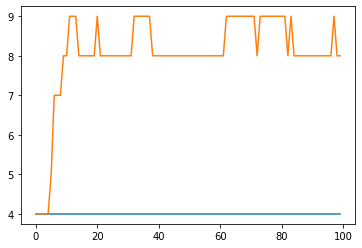

In [ ]:
# train set auto regression plotting
plt.plot(yhat,label="prediction")
plt.show()
plt.plot(bb, label="real")
plt.show()
plt.plot(yhat,label="prediction")
plt.plot(bb, label="real")